## Introduction

* **Natural Language Processing (NLP) :** Discipline relevant de l'informatique, de l'intelligence artificielle et de la linguistique, qui s'intéresse à la création de modèles computationnels capables de traiter et de comprendre le langage naturel. Cela inclut, par exemple : la compréhension sémantique des mots (ex. : *cat* et *dog* sont plus proches sémantiquement que *cat* et *spoon*), la synthèse vocale (*text-to-speech*), la traduction automatique, et bien plus encore.

* **Sentiment Analysis :** Il s'agit de l'interprétation et de la classification des émotions (positives, négatives et neutres) dans des données textuelles à l'aide de techniques d'analyse de texte. L'analyse de sentiments permet aux organisations d'identifier l'opinion publique vis-à-vis de certains mots ou sujets.

Dans ce notebook, nous allons développer un **modèle de Sentiment Analysis** afin de catégoriser un tweet comme étant **positif ou négatif.**

## Table des Matières
1. [Importation des dépendances](#p1)
2. [Importation du dataset](#p2)
3. [Prétraitement du texte](#p3)
4. [Analyse des données](#p4)
5. [Séparation des données](#p5)
6. [Vectoriseur TF-IDF](#p6)
7. [Transformation du dataset](#p7)
8. [Création et évaluation des modèles](#p8)
    * [Modèle BernoulliNB](#p8-1)
    * [Modèle LinearSVC](#p8-2)
    * [Modèle de Logistic Regression](#p8-3)
9. [Sauvegarde des modèles](#p9)
10. [Utilisation du modèle](#p10)

## <a name="p1">Importation des dépendances</a>


In [3]:
!pip install wordcloud

   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/301.2 kB 220.2 kB/s eta 0:00:02
   -------------- ----------------------- 112.6/301.2 kB 731.4 kB/s eta 0:00:01
   ---------------------------------------  297.0/301.2 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 1.6 MB/s eta 0:00:00


In [13]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## <a name="p2">Importation du dataset</a>

Le dataset utilisé est le **sentiment140 dataset**. Il contient 1 600 000 tweets extraits à l'aide de la **Twitter API**. Les tweets ont été annotés **(0 = Négatif, 4 = Positif)** et peuvent être utilisés pour détecter le sentiment.

*Le jeu de données d'entraînement n'est pas parfaitement catégorisé, car les tweets ont été étiquetés en fonction des emojis présents dans le texte. Ainsi, tout modèle construit à partir de ce dataset pourrait avoir une précision inférieure aux attentes, du fait de cette annotation approximative.*

**Il contient les 6 champs suivants :**
1. **sentiment** : la polarité du tweet *(0 = négatif, 4 = positif)*
2. **ids** : l’identifiant du tweet *(2087)*
3. **date** : la date du tweet *(Sat May 16 23:58:44 UTC 2009)*
4. **flag** : la requête (lyx). Si aucune requête n’est associée, la valeur est NO_QUERY.
5. **user** : l’utilisateur ayant tweeté *(robotickilldozr)*
6. **text** : le contenu du tweet *(Lyx is cool)*

Nous n’avons besoin que des champs **sentiment** et **text**, donc nous ignorons les autres.

Par ailleurs, nous allons modifier le champ **sentiment** pour lui attribuer de nouvelles valeurs correspondant mieux à l’interprétation du sentiment : **(0 = Négatif, 1 = Positif)**


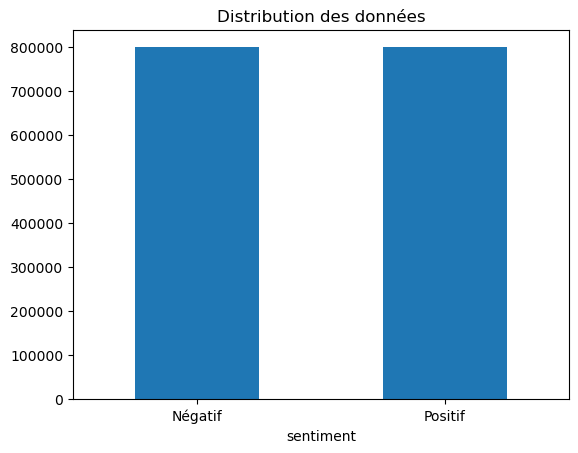

In [6]:
# Importation du dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('C:/Users/AK/Desktop/Projets/Analyse des Sentiments sur Twitter/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Suppression des colonnes non nécessaires
dataset = dataset[['sentiment', 'text']]

# Remplacement des valeurs pour faciliter la compréhension
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)

# Affichage de la distribution des sentiments dans le dataset
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution des données',
                                               legend=False)
ax.set_xticklabels(['Négatif', 'Positif'], rotation=0)

# Stockage des données dans des listes
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

## <a name="p3">Prétraitement du texte</a>

Le **prétraitement du texte** est traditionnellement une étape importante dans les tâches de **Natural Language Processing (NLP)**. Il permet de transformer le texte en une forme plus exploitable pour que les algorithmes de machine learning puissent mieux fonctionner.

**Les étapes de prétraitement appliquées sont les suivantes :**
1. **Conversion en minuscules :** Chaque texte est converti en lettres minuscules.
2. **Remplacement des URLs :** Les liens commençant par **"http"**, **"https"** ou **"www"** sont remplacés par **"URL"**.
3. **Remplacement des emojis :** Les emojis sont remplacés en utilisant un dictionnaire prédéfini contenant les emojis et leur signification. *(ex : ":)" devient "EMOJIsmile")*
4. **Remplacement des noms d’utilisateurs :** Les mentions de type @Username sont remplacées par le mot **"USER"**. *(ex : "@Kaggle" devient "USER")*
5. **Suppression des caractères non alphabétiques :** Tous les caractères sauf les chiffres et les lettres sont remplacés par un espace.
6. **Réduction des lettres répétées :** Trois lettres consécutives ou plus sont réduites à deux. *(ex : "Heyyyy" devient "Heyy")*
7. **Suppression des mots courts :** Les mots ayant une longueur inférieure à 2 caractères sont supprimés.
8. **Suppression des stopwords :** Les *stopwords* sont des mots en anglais qui n’ajoutent pas beaucoup de sens à une phrase. On peut les ignorer sans perdre le sens général de la phrase. *(ex : "the", "he", "have")*
9. **Lemmatisation :** La lemmatisation consiste à transformer un mot en sa forme de base. *(devientreat” devent “Good”)*


In [7]:
# Définition d’un dictionnaire contenant tous les emojis avec leur signification.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Définition d’un ensemble contenant tous les stopwords en anglais.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [10]:
def preprocess(textdata):
    processedText = []
    
    # Création d’un lemmatiseur.
    wordLemm = WordNetLemmatizer()
    
    # Définition des expressions régulières.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = r'@[^\s]+'
    alphaPattern      = r"[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()  # Conversion du tweet en minuscules.
        
        # Remplacer toutes les URLs par 'URL'
        tweet = re.sub(urlPattern, ' URL', tweet)
        
        # Remplacer tous les emojis par leur signification.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        
        # Remplacer les @USERNAME par 'USER'.
        tweet = re.sub(userPattern, ' USER', tweet)
        
        # Supprimer tous les caractères non alphanumériques.
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Réduire les lettres consécutives (3 ou plus) à seulement 2.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Vérifier que le mot a plus d'une lettre (filtrage des mots très courts).
            if len(word) > 1:
                # Lemmatisation du mot.
                word = wordLemm.lemmatize(word)
                tweetwords += (word + ' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [15]:
import time
t = time.time()
nltk.download('wordnet')
nltk.download('omw-1.4')
processedtext = preprocess(text)

print("Prétraitement du texte terminé.")
print(f"Temps écoulé : {round(time.time() - t)} secondes")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AK\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\AK\AppData\Roaming\nltk_data...


Prétraitement du texte terminé.
Temps écoulé : 252 secondes


## <a name="p4">Analyse des données</a>

Nous allons maintenant analyser les données prétraitées afin de mieux les comprendre. Nous allons générer des **nuages de mots (Word Clouds)** pour les tweets **positifs** et **négatifs** de notre dataset, afin d’observer quels mots reviennent le plus fréquemment.


### Nuage de mots pour les tweets négatifs


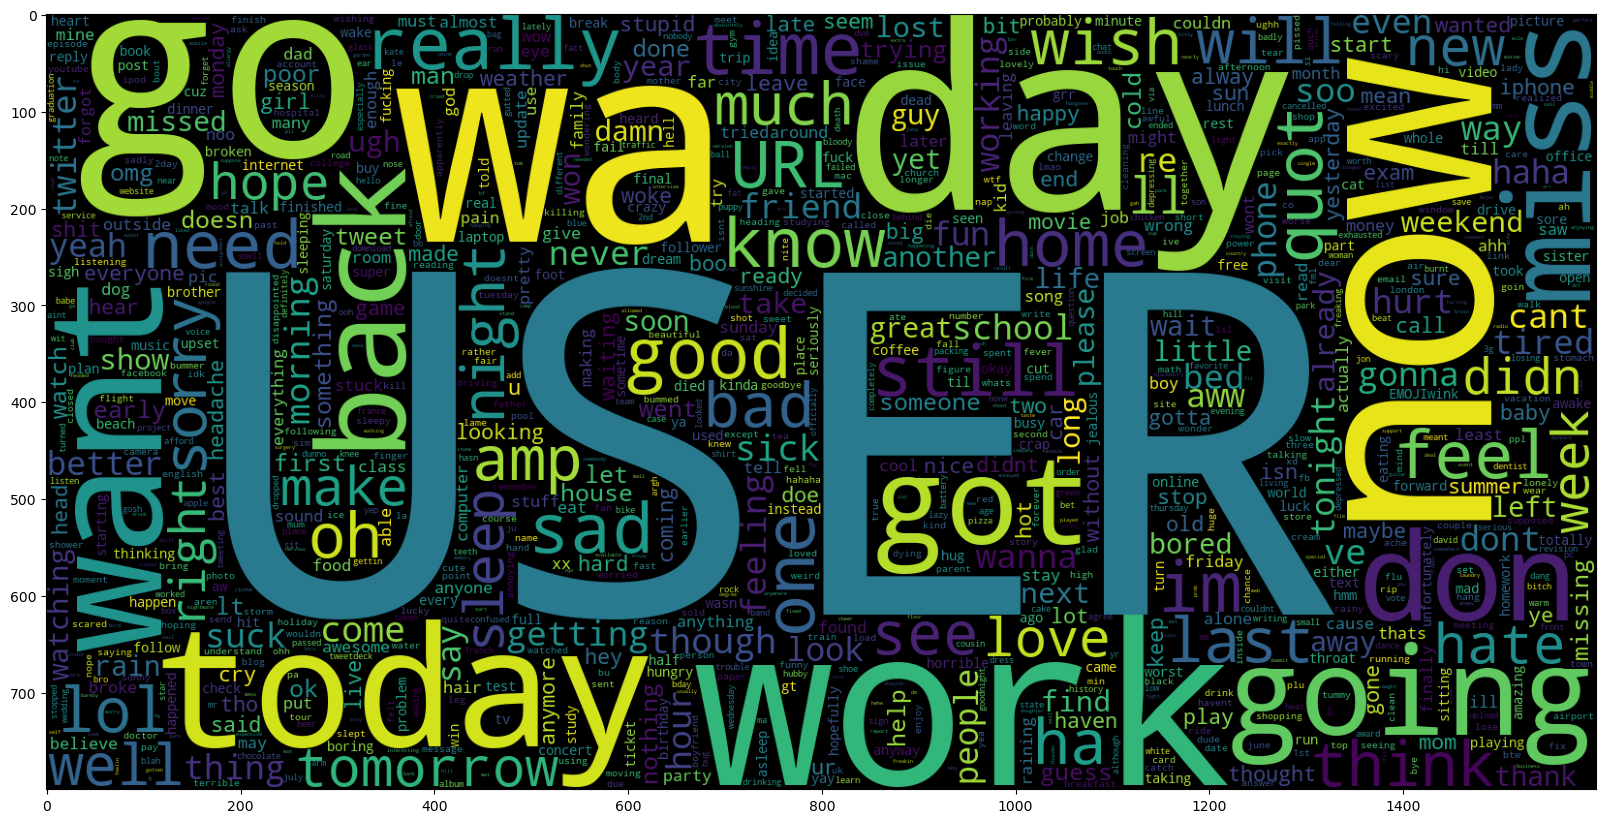

In [20]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

### Nuage de mots pour les tweets positifs


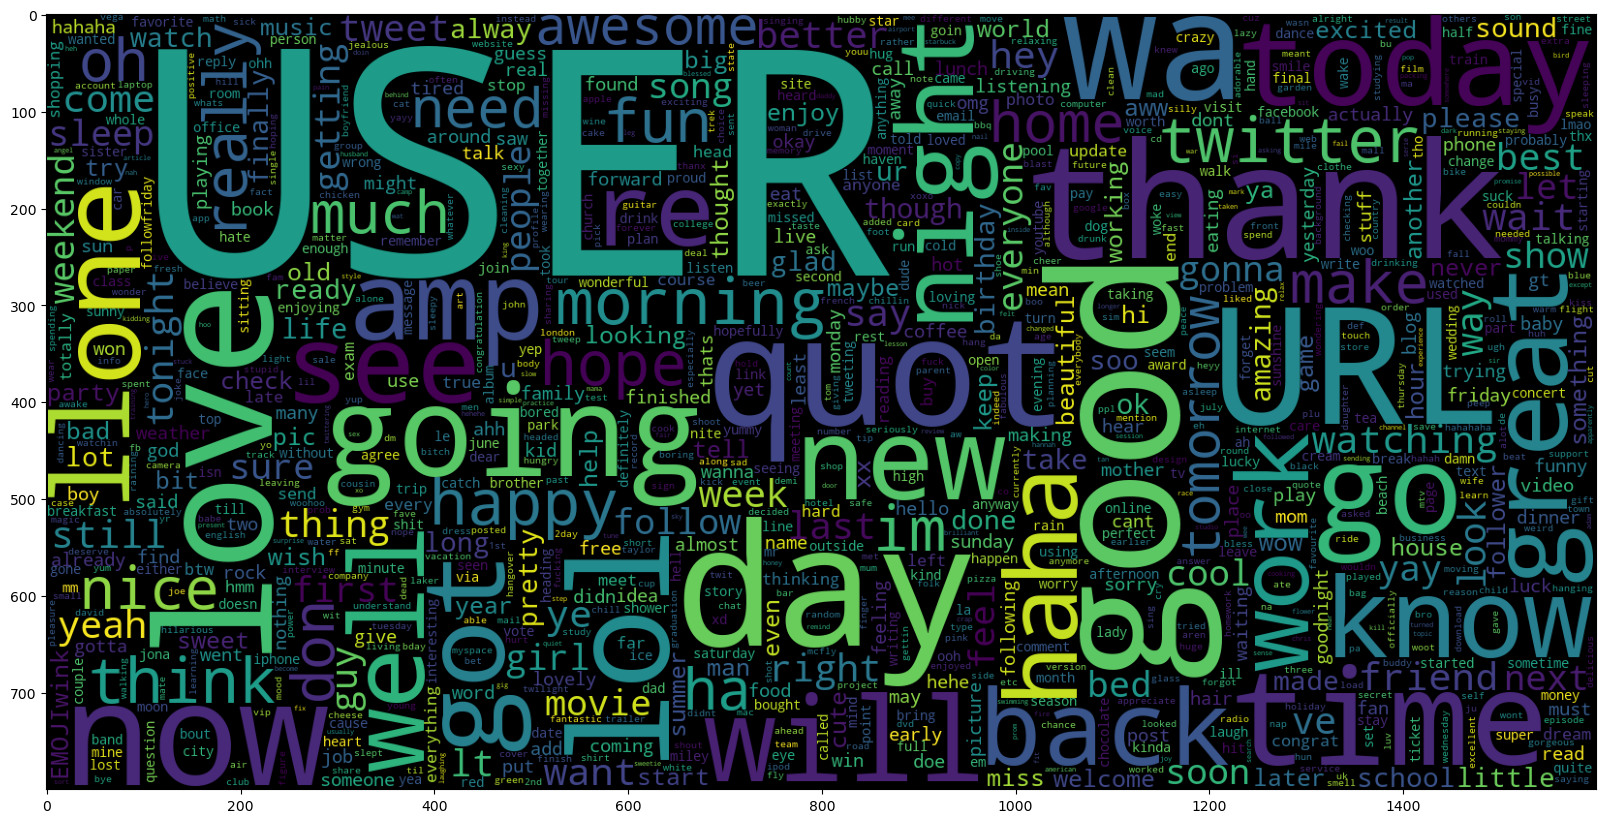

In [21]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

## <a name="p5">Séparation des données</a>

Les données prétraitées sont divisées en deux ensembles :

* **Données d'entraînement :** Ensemble de données sur lequel le modèle sera entraîné. Il contient 95 % des données.
* **Données de test :** Ensemble de données utilisé pour évaluer les performances du modèle. Il contient 5 % des donées.


In [22]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size=0.05, random_state=0)

print("Séparation des données effectuée.")

Séparation des données effectuée.


## <a name="p6">Vectoriseur TF-IDF</a>

**TF-IDF indique l’importance d’un mot pour comprendre un document ou un ensemble de documents.** Illustrons cela avec un exemple : supposons que vous ayez un dataset dans lequel des étudiants rédigent une rédaction sur le thème "Ma maison". Dans ce dataset, le mot "a" apparaît très souvent ; c’est un mot à haute fréquence par rapport aux autres mots du corpus. D’autres mots comme *home*, *house*, *rooms*, etc., apparaissent moins fréquemment : leur fréquence est plus faible, mais ils portent plus d'information. C’est cette intuition qui est à la base du TF-IDF.

Le **TF-IDF Vectoriser** convertit une collection de documents bruts en une **matrice de caractéristiques TF-IDF**. Le **Vectoriseur** est généralement entraîné uniquement sur le dataset **X_train**.

**ngram_range** définit l’intervalle du nombre de mots pris en compte dans une séquence.  
*Par exemple : "very expensive" est un 2-gram, considéré comme une caractéristique distincte de "very" et "expensive" si on utilise un n-gramme de type (1,2).*

**max_features** spécifie le nombre de caractéristiques à conserver.  
*(Les plus fréquentes dans l’ensemble du corpus)*


In [24]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectoriser.fit(X_train)

print("Vectoriseur entraîné.")
print("Nombre de mots caractéristiques :", len(vectoriser.get_feature_names_out()))

Vectoriseur entraîné.
Nombre de mots caractéristiques : 500000


## Transformation du dataset

Nous allons transformer les datasets **X_train** et **X_test** en matrices de caractéristiques **TF-IDF** à l’aide du **TF-IDF Vectoriser**.  
Ces jeux de données transformés seront utilisés pour entraîner le modèle et l’évaluer.


In [26]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

print("Données transformées.")

Données transformées.


## <a name="p8">Création et évaluation des modèles</a>

Nous allons créer 3 types de modèles différents pour notre problème d’analyse de sentiments :  
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**

Étant donné que notre dataset n’est pas **déséquilibré** (c’est-à-dire qu’il contient un nombre équivalent de tweets **positifs** et **négatifs**), nous choisissons **l’accuracy** (précision globale) comme métrique d’évaluation.  

En complément, nous tracerons la **matrice de confusion** afin de mieux comprendre comment le modèle se comporte pour chaqu classe.


### Fonction d’évaluation du modèle



In [28]:
def model_Evaluate(model):
    # Prédire les valeurs sur le jeu de test
    y_pred = model.predict(X_test)

    # Afficher les métriques d’évaluation
    print(classification_report(y_test, y_pred))

    # Calcul et affichage de la matrice de confusion
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Négatif', 'Positif']
    group_names = ['Vrai Négatif', 'Faux Positif', 'Faux Négatif', 'Vrai Positif']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Valeurs prédites", fontdict={'size':14}, labelpad=10)
    plt.ylabel("Valeurs réelles", fontdict={'size':14}, labelpad=10)
    plt.title("Matrice de confusion", fontdict={'size':18}, pad=20)

### <a name="p8-1">Modèle BernoulliNB</a>


              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



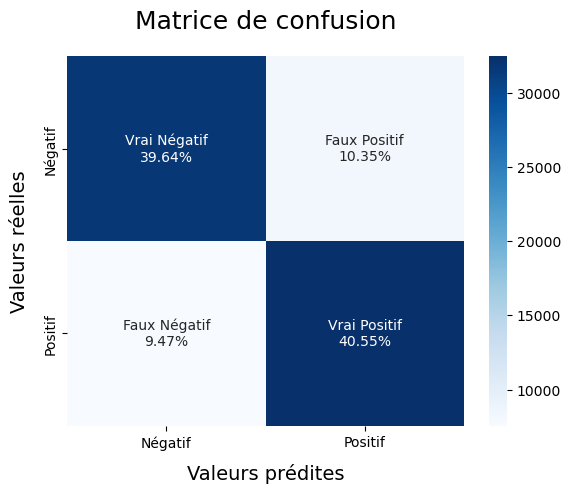

In [29]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### <a name="p8-2">Modèle LinearSVC</a>


C:\Users\AK\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



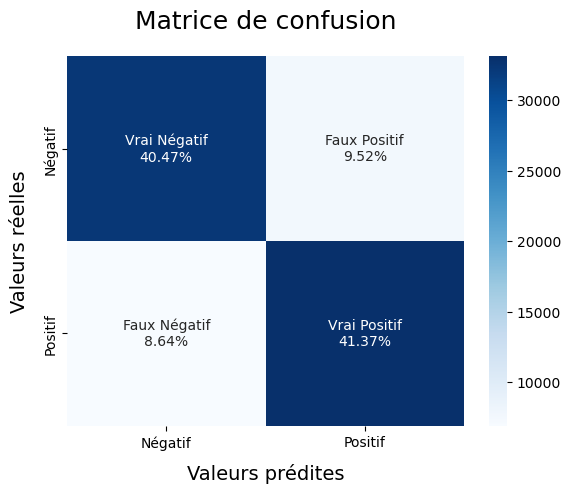

In [30]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

### <a name="p8-3">Modèle de Régression Logistique</a>


              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



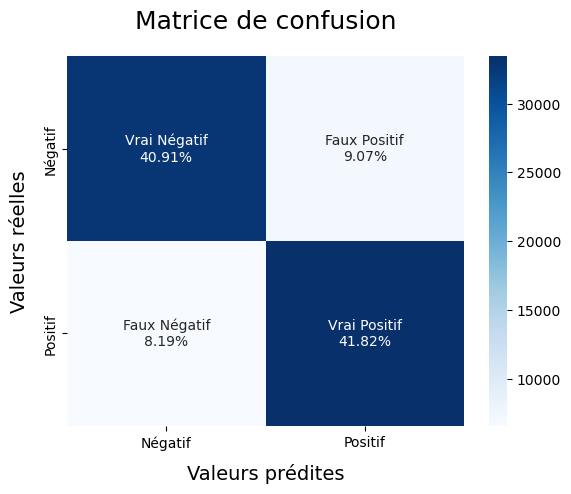

In [31]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

On peut clairement constater que le **modèle de Régression Logistique** est celui qui donne les meilleurs résultats parmi tous les modèles testés. Il atteint une **précision de près de 82 %** pour la classification du sentiment d’un tweet.

Cela dit, il est également important de noter que le **modèle BernoulliNB** est le plus rapide à entraîner et à prédire. Il atteint également une **précision de 80 %**, ce qui reste très satisfaisant.


## <a name="p9">Sauvegarde des modèles</a>

Nous utilisons **PICKLE** pour sauvegarder le **Vectoriseur**, ainsi que les modèles **BernoulliNB** et **Régression Logistique** pour une utilisation ultérieure.


In [32]:
# Sauvegarde du vectoriseur TF-IDF
file = open('vectoriser-ngram-(1,2).pickle', 'wb')
pickle.dump(vectoriser, file)
file.close()

# Sauvegarde du modèle de Régression Logistique
file = open('Sentiment-LR.pickle', 'wb')
pickle.dump(LRmodel, file)
file.close()

# Sauvegarde du modèle Bernoulli Naive Bayes
file = open('Sentiment-BNB.pickle', 'wb')
pickle.dump(BNBmodel, file)
file.close()

## <a name="p10">Utilisation du modèle</a>

Pour utiliser le modèle de **prédiction de sentiment**, il faut importer le **Vectoriseur** et le **modèle de Régression Logistique (LR)** à l’aide de **Pickle**.

Le vectoriseur permet de transformer le texte en une matrice de caractéristiques **TF-IDF**.  
Le modèle, quant à lui, permet de prédire le **sentiment** du texte transformé.

Cependant, le texte dont on souhaite prédire le sentiment doit d'abord être **prétrité**.


In [36]:
def charger_modeles():
    # Charger le vectoriseur
    file = open('C:/Users/AK/Desktop/Projets/Analyse des Sentiments sur Twitter/vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    
    # Charger le modèle de Régression Logistique
    file = open('C:/Users/AK/Desktop/Projets/Analyse des Sentiments sur Twitter/Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predire_sentiment(vectoriser, model, texte):
    # Prétraitement + vectorisation du texte
    texte_vectorise = vectoriser.transform(preprocess(texte))
    
    # Prédiction du sentiment
    prediction = model.predict(texte_vectorise)
    
    # Création d'une liste associant texte et prédiction
    donnees = []
    for t, p in zip(texte, prediction):
        donnees.append((t, p))
        
    # Conversion en DataFrame
    df = pd.DataFrame(donnees, columns=['Texte', 'Sentiment'])
    df = df.replace([0, 1], ["Négatif", "Positif"])
    return df

if __name__ == "__main__":
    # Chargement des modèles
    # vectoriser, LRmodel = charger_modeles()

    # Liste de textes à classer
    phrases_positives = [
    "Although the movie had a slow start, the emotional payoff in the end was totally worth it.",
    "I wasn’t sure at first, but I grew to appreciate the depth of the story.",
    "Her dedication and passion for her work are truly inspiring.",
    "Despite the technical issues, the customer service made the experience great.",
    "This product exceeded my expectations in every possible way.",
]
    phrases_negatives = [
    "I tried to like it, but it just kept getting worse with every episode.",
    "The presentation was decent, but the lack of substance made it hard to follow.",
    "It could have been amazing, but they completely missed the mark.",
    "Even though the packaging was nice, the product itself was disappointing.",
    "I expected more professionalism, especially after paying such a high price.",
]


df = predire_sentiment(vectoriser, LRmodel, phrases_positives + phrases_negatives)
print(df.head())
df = predire_sentiment(vectoriser, LRmodel, phrases_positives + phrases_negatives)
print(df.head())


                                               Texte Sentiment
0  Although the movie had a slow start, the emoti...   Positif
1  I wasn’t sure at first, but I grew to apprecia...   Positif
2  Her dedication and passion for her work are tr...   Positif
3  Despite the technical issues, the customer ser...   Positif
4  This product exceeded my expectations in every...   Positif
